# PokéMAM

- EL KHALFIOUI Nadir 
- EL KHAMLICHI Badreddine 
- LEHLALI Hèdi

# Preprocess

## Librairies

In [1]:
import cv2
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objects as go
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf

## Données


In [2]:
#extraire les données du fichier zip à partir du directory path du zip
from zipfile import ZipFile
file_name = "archive.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done')

FileNotFoundError: [Errno 2] No such file or directory: 'archive.zip'

In [2]:
import pathlib # pour les chemins
import os # pour les chemins
data_dir = pathlib.Path('dataset') # chemin du dossier dataset
print(data_dir) #
print(os.path.abspath(data_dir)) 
image_count = len(list(data_dir.glob('*/*'))) # compte le nombre d'images
print(image_count)

dataset
d:\Téléchargement\Cours\MAM4A\Projet PokéMAM\Projet\dataset
1780


Dans cette cellule, nous importons les bibliothèques 'pathlib' et 'os' pour travailler avec les chemins de fichiers et les opérations sur le système de fichiers.

- pathlib : Cette bibliothèque fournit des classes et des méthodes pour la manipulation des chemins de fichiers. Nous l'utilisons ici pour créer un objet Path représentant le répertoire "dataset".

- os : Cette bibliothèque fournit des fonctions permettant d'effectuer des opérations sur le système d'exploitation, notamment l'accès aux variables d'environnement et la manipulation de chemins de fichiers.

Ensuite, nous utilisons pathlib.Path pour créer un objet Path représentant le répertoire "dataset". Cela nous permet de travailler avec le chemin de ce répertoire de manière plus facile et portable.

Enfin, nous utilisons glob() pour rechercher tous les fichiers présents dans data_dir et ses sous-répertoires. La fonction len() est utilisée pour compter le nombre total de fichiers trouvés, ce qui nous donne une indication du nombre d'images disponibles dans le répertoire.

In [3]:
# code qui recuperer le nom des dossiers dns le dossier dataset dans un variable class_names
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
#transformer class_names en dataframes
class_names = pd.DataFrame(class_names)

Ensuite, nous créons les dossiers train, test et val pour chaque classe du jeu de données.

In [4]:
import os
from shutil import copyfile
os.mkdir('train/')
os.mkdir('test/')
os.mkdir('val/')
# créer les dossiers train, test et val pour chaque classe
for i in range(len(class_names)):
    os.mkdir('train/'+class_names[0][i])
    os.mkdir('test/'+class_names[0][i])
    os.mkdir('val/'+class_names[0][i])


On charge ensuite les images du répertoire `data_dir` dans les dossiers `train`, `test` et `val`. Pour chaque classe dans `class_names`, on sélectionne un sous-ensemble d'images selon un ratio spécifique (70% pour `train`, 20% pour `test` et 10% pour `val`), puis on les copie du répertoire d'origine vers les dossiers correspondants (`train`, `test` ou `val`) en préservant leur classe.

In [5]:
# Charger les images dans les dossiers train, test et val
import random
import shutil
for i in range(len(class_names)):
    for item in random.sample(os.listdir(data_dir/class_names[0][i]), int(0.7*len(os.listdir(data_dir/class_names[0][i])))):
        s = os.path.join(data_dir/class_names[0][i], item)
        d = os.path.join('train/'+class_names[0][i], item)
        shutil.copyfile(s, d)
    for item in random.sample(os.listdir(data_dir/class_names[0][i]), int(0.2*len(os.listdir(data_dir/class_names[0][i])))):
        s = os.path.join(data_dir/class_names[0][i], item)
        d = os.path.join('test/'+class_names[0][i], item)
        shutil.copyfile(s, d)
    for item in random.sample(os.listdir(data_dir/class_names[0][i]), int(0.1*len(os.listdir(data_dir/class_names[0][i])))):
        s = os.path.join(data_dir/class_names[0][i], item)
        d = os.path.join('val/'+class_names[0][i], item)
        shutil.copyfile(s, d)

On utilise ensuite la classe `ImageDataGenerator` de Keras pour générer des lots d'images augmentées pour l'entraînement (`train_data`) et la validation (`val_data`). On spécifie des transformations telles que la rotation, le zoom et le décalage pour augmenter la diversité des données d'entraînement. De plus, on crée également un générateur de données de test (`test_data`) sans augmentation pour évaluer les performances du modèle sur des données non vues.

In [6]:
from keras.preprocessing.image import ImageDataGenerator #importer ImageDataGenerator 
batch_size = 3 #nombre d'images à traiter à chaque étape
img_height = 200 #hauteur de l'image
img_width = 200 #largeur de l'image

train_datagen = ImageDataGenerator( #créer un objet ImageDataGenerator pour les données d'entraînement
    rotation_range=10, #faire pivoter l'image de 10 degrés
    zoom_range=0.1, #zoomer l'image de 10%
    width_shift_range=0.1, #déplacer l'image horizontalement de 10%
    height_shift_range=0.1, #déplacer l'image verticalement de 10%
    horizontal_flip=True #retourner l'image horizontalement
)

val_datagen = ImageDataGenerator() #créer un objet ImageDataGenerator pour les données de validation et de test 

train_data = train_datagen.flow_from_directory( #créer un générateur de données d'entraînement à partir du dossier 'train' 
    'train', #chemin du dossier 'train'
    target_size=(img_height, img_width), #redimensionner toutes les images à 200x200
    batch_size=batch_size, #nombre d'images à traiter à chaque étape
    class_mode='sparse', #type de labels retournés
    shuffle=True #mélanger les données
)

val_data = val_datagen.flow_from_directory( #créer un générateur de données de validation à partir du dossier 'val'
    'val', #chemin du dossier 'val'
    target_size=(img_height, img_width), #redimensionner toutes les images à 200x200
    batch_size=batch_size, #nombre d'images à traiter à chaque étape
    class_mode='sparse', #type de labels retournés
    shuffle=False #ne pas mélanger les données
)

test_data = val_datagen.flow_from_directory( #créer un générateur de données de test à partir du dossier 'test'
    'test', #chemin du dossier 'test'
    target_size=(img_height, img_width), #redimensionner toutes les images à 200x200
    batch_size=batch_size, #nombre d'images à traiter à chaque étape
    class_mode='sparse', #type de labels retournés
    shuffle=False  #ne pas mélanger les données
)

Found 1238 images belonging to 10 classes.
Found 173 images belonging to 10 classes.
Found 352 images belonging to 10 classes.


In [7]:
class_names = list(train_data.class_indices.keys()) # récupérer les noms des classes
print(class_names) # afficher les noms des classes


['bulbizarre', 'carapuce', 'evoli', 'lokhlass', 'mewtwo', 'onix', 'pikachu', 'rondoudou', 'ronflex', 'salameche']


On utilise la bibliothèque Matplotlib pour afficher un échantillon d'images et leurs étiquettes à partir du générateur train_data. On itère sur les images et les étiquettes pour afficher trois images avec leurs titres correspondant aux classes prédites.

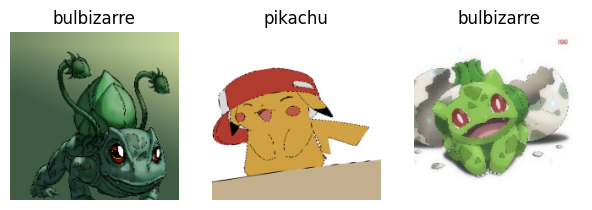

In [8]:
plt.figure(figsize=(10, 10)) 
images, labels = next(iter(train_data)) # récupérer un lot d'images du générateur de données
for i in range(3): # afficher les 3 premières images
    ax = plt.subplot(1, 4, i + 1) # créer une sous-figure
    plt.imshow(images[i].astype("uint8")) # afficher l'image
    plt.title(class_names[int(labels[i])]) # afficher le label de l'image
    plt.axis("off") 


# CNN - Modèle

On définit un modèle séquentiel avec différentes couches de convolution et de pooling, suivi d'une couche dense pour la classification. On compile le modèle avec l'optimiseur Adam, la perte de catégorie croisée creuse et la métrique d'exactitude. On crée également un rappel TensorBoard pour la visualisation des métriques pendant l'entraînement.

In [9]:
from tensorflow.keras import layers #importer les couches de Keras

num_classes = len(class_names) #nombre de classes

model = tf.keras.Sequential([ #créer un modèle séquentiel 
    layers.experimental.preprocessing.Rescaling(1./255), #normaliser les valeurs des pixels entre 0 et 1 
    layers.Conv2D(128,4, activation='relu'), #ajouter une couche de convolution avec 128 filtres, une fenêtre de 4x4 et une fonction d'activation 'relu'
    layers.MaxPooling2D(), #ajouter une couche de pooling avec une fenêtre de 2x2 

    layers.Conv2D(64,4, activation='relu'), 
    layers.MaxPooling2D(), 

    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(), #transformer la matrice 3D en vecteur 1D 
    layers.Dense(64,activation='relu'), #ajouter une couche dense avec 64 neurones et une fonction d'activation 'relu' 
    layers.Dense(num_classes, activation='softmax') #ajouter une couche dense avec 5 neurones et une fonction d'activation 'softmax' 
])

model.compile(optimizer='adam', #choisir l'optimiseur 'adam' 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), #choisir la fonction de coût 'SparseCategoricalCrossentropy' 
  metrics=['accuracy'],) #choisir la métrique d'évaluation 'accuracy'

logdir="logs" #définir le dossier de sauvegarde des logs

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir, 
                                                   embeddings_data=train_data) #créer un callback pour Tensorboard


Le code ci-dessus définit donc un modèle de réseau de neurones convolutifs (CNN) utilisant l'API séquentielle de Keras. Voici les différentes couches du modèle :

1. layers.experimental.preprocessing.Rescaling(1./255): Cette couche est ajoutée pour normaliser les valeurs des pixels des images d'entrée entre 0 et 1, en divisant chaque pixel par 255.

2. layers.Conv2D(128,4, activation='relu'): Une couche de convolution 2D avec 128 filtres, une taille de noyau de 4x4 et une fonction d'activation ReLU.

3. layers.MaxPooling2D(): Une couche de pooling 2D qui réduit la dimensionnalité spatiale en prenant les valeurs maximales dans une fenêtre de pooling.

4. Les couches 2 et 3 sont répétées avec différentes configurations pour extraire des caractéristiques plus complexes à partir des images.

5. layers.Flatten(): Cette couche aplatisse les caractéristiques en un vecteur avant de les passer à une couche dense.

6. layers.Dense(64, activation='relu'): Une couche dense avec 64 neurones et une fonction d'activation ReLU.

7. layers.Dense(num_classes, activation='softmax'): Une couche de sortie avec un nombre de neurones égal au nombre de classes, utilisant une fonction d'activation softmax pour obtenir des probabilités de classification.

Ensuite, le modèle est compilé avec l'optimiseur Adam, qui ajuste les poids du modèle pour minimiser la perte lors de l'entraînement. La perte utilisée est la perte de catégorie croisée creuse, adaptée à la classification multi-classes. La métrique d'exactitude est également spécifiée pour évaluer les performances du modèle.

! Attention avant de run la cellule suivante : ici 20(54min) Epochs peut durer jusqu'à 50-60 min, priviligiéz 5 ou 10 (28min) epochs pour un temps d'exécution compris entre 10 et 20 minutes

In [11]:
history = model.fit(  #entraîner le modèle
  train_data, #données d'entraînement
  validation_data=val_data, #données de validation
  epochs=10 #nombre d'époques
  #callbacks=[tensorboard_callback] 
)

Epoch 1/10


c:\Users\Nadir\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


101/413 [======>.......................] - ETA: 1:17 - loss: 2.0923 - accuracy: 0.1815

c:\Users\Nadir\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


413/413 [==============================] - 111s 268ms/step - loss: 1.7945 - accuracy: 0.3360 - val_loss: 1.4789 - val_accuracy: 0.5029
Epoch 2/10
413/413 [==============================] - 111s 269ms/step - loss: 1.4497 - accuracy: 0.5105 - val_loss: 1.2599 - val_accuracy: 0.6243
Epoch 3/10
413/413 [==============================] - 115s 278ms/step - loss: 1.3794 - accuracy: 0.5404 - val_loss: 1.1082 - val_accuracy: 0.6069
Epoch 4/10
413/413 [==============================] - 103s 249ms/step - loss: 1.2620 - accuracy: 0.5816 - val_loss: 0.9905 - val_accuracy: 0.6705
Epoch 5/10
413/413 [==============================] - 105s 254ms/step - loss: 1.1611 - accuracy: 0.6155 - val_loss: 1.0423 - val_accuracy: 0.6416
Epoch 6/10
413/413 [==============================] - 117s 283ms/step - loss: 1.0925 - accuracy: 0.6341 - val_loss: 0.8766 - val_accuracy: 0.6879
Epoch 7/10
413/413 [==============================] - 115s 279ms/step - loss: 1.0245 - accuracy: 0.6591 - val_loss: 0.8319 - val_accura

On a utilisé la méthode `model.fit()` pour entraîner notre modèle. Cette méthode prend en entrée les données d'entraînement (`train_data`) et les données de validation (`val_data`) que nous avons préparées précédemment. On a défini que l'entraînement se fera sur 20 epochs, ce qui signifie qu'on va parcourir l'ensemble des données d'entraînement 20 fois.

Pendant chaque epoch, le modèle est ajusté en fonction des gradients calculés à partir des données d'entraînement. On utilise ces gradients pour mettre à jour les poids du modèle et améliorer sa performance. En parallèle, on évalue la performance du modèle sur les données de validation pour voir comment il se comporte sur des exemples qu'il n'a pas encore vus.

On a également utilisé le callback `tensorboard_callback` pour enregistrer les métriques et les statistiques du modèle pendant l'entraînement. Ce callback permet d'utiliser TensorBoard pour visualiser ces informations ultérieurement et analyser les performances du modèle.

À la fin de l'entraînement, on obtient un historique de l'entraînement dans l'objet `history`. Cela contient des informations sur les métriques d'entraînement et de validation pour chaque epoch. On peut utiliser ces informations pour évaluer la performance du modèle, détecter d'éventuels problèmes de surapprentissage (overfitting) ou sous-apprentissage (underfitting), et ajuster les paramètres du modèle si nécessaire.

En résumé, l'appel à `model.fit()` nous permet d'entraîner notre modèle sur les données d'entraînement, de le valider sur les données de validation, et de collecter des informations sur ses performances tout au long du processus d'entraînement.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None)  0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 128)   6272      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 128)  0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    131136    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    3

On a utilisé la fonction model.summary() pour obtenir un résumé du modèle que nous avons construit. En analysant le résumé, on trouve que notre modèle est de type "sequential" et qu'il est composé de plusieurs couches, dont des couches de convolution 2D, de max pooling 2D, et des couches entièrement connectées.

Les couches de convolution 2D appliquent des filtres aux régions locales de l'image pour extraire des caractéristiques. Les couches de max pooling 2D réduisent la taille des cartes de caractéristiques en conservant les valeurs maximales. La couche de flattening transforme les cartes de caractéristiques en un vecteur unidimensionnel. Les couches entièrement connectées sont utilisées pour la classification.

Le modèle compte un total de 262 074 paramètres, qui sont tous entraînables. Ces paramètres comprennent les poids et les biais des différentes couches. L'analyse du modèle et du nombre de paramètres nous permet de comprendre la complexité et la capacité du modèle à apprendre à partir des données.

## Précision du modèle

In [13]:
fig = go.Figure()
epochs = []
for i in range(len(history.history['accuracy'])):
    epochs.append(i)
fig.add_trace(go.Scatter(x=epochs,y=history.history['accuracy'], mode='lines',name='train'))
fig.add_trace(go.Scatter(x=epochs,y=history.history['val_accuracy'], mode='lines',name='val'))
fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'width': 500, 
        'height': 400

})
fig.show()

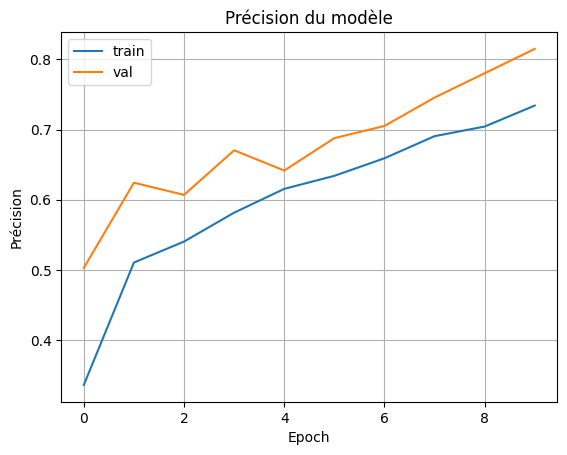

In [14]:
# plot accuracy avec matplotlib
plt.plot(history.history['accuracy']) #afficher l'accuracy du modèle sur les données d'entraînement
plt.plot(history.history['val_accuracy']) #afficher l'accuracy du modèle sur les données de validation
plt.title('Précision du modèle') 
plt.ylabel('Précision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
#grid
plt.grid(True)
plt.show()


Le graphique montre l'évolution de la précision du modèle au cours de l'entraînement. Les courbes bleue et orange représentent respectivement la précision sur l'ensemble d'entraînement et sur l'ensemble de validation. On observe une augmentation progressive de la précision au fur et à mesure des epochs. Vers la fin, la précision se stabilise autour de 0,8 à 0,9, ce qui indique que le modèle atteint une performance satisfaisante.

# Prédiction

##### Fonction qui prédit la catégorie d'une image à partir du modèle 

In [15]:
def predict_image(model, img): #fonction qui prédit la catégorie d'une image à partir du modèle

    img_array = keras.preprocessing.image.img_to_array(img) #convertir l'image en tableau numpy
    img_array = tf.expand_dims(img_array, 0) #ajouter une dimension pour avoir un lot d'une seule image

    predictions = model.predict(img_array) #faire la prédiction
    score = tf.nn.softmax(predictions[0]) #calculer la probabilité de chaque classe
    print(score) #afficher les probabilités
    print(
        "C'est un {}"# avec {:.2f} % de chance."
        .format(class_names[np.argmax(score)], 100 * np.max(score)) #afficher la classe ayant la plus grande probabilité
    )
    return predictions #retourner les prédictions


In [16]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

def thepokemon(dir_image):
    img_height = 200
    img_width = 200

    img = tf.keras.preprocessing.image.load_img(dir_image, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    df = pd.read_csv('Pokemon-2.csv')
    df_sorted = df.sort_values('Name')  # Tri du dataframe par le nom du Pokémon
    pokemon = df_sorted[df_sorted['Name'] == class_names[np.argmax(predictions[0])]]

    # Affichage amélioré des informations du Pokémon prédit
    print(pokemon.to_string(index=False))

    # Créer la disposition en grille avec 1 ligne et 2 colonnes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Afficher l'image dans le premier sous-graphique
    ax1.imshow(img)
    ax1.set_title('Image')

    # Afficher l'histogramme dans le deuxième sous-graphique
    ax2.bar(class_names, predictions[0])
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Prédictions')
    ax2.set_title('Histogramme des prédictions')
    ax2.set_xticklabels(class_names, rotation=45)

    # Ajuster les espacements entre les sous-graphiques
    plt.tight_layout()

    plt.show()




##### Choisissez votre pokémon à prédire !

1/1 [==============================] - 0s 79ms/step
  #   Name  Type 1 Type 2  Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation  Legendary
150 mewtwo Psychic    NaN    680 106     110       90      154       90    130           1       True


C:\Users\Nadir\AppData\Local\Temp\ipykernel_14896\440573832.py:34: UserWarning:

FixedFormatter should only be used together with FixedLocator



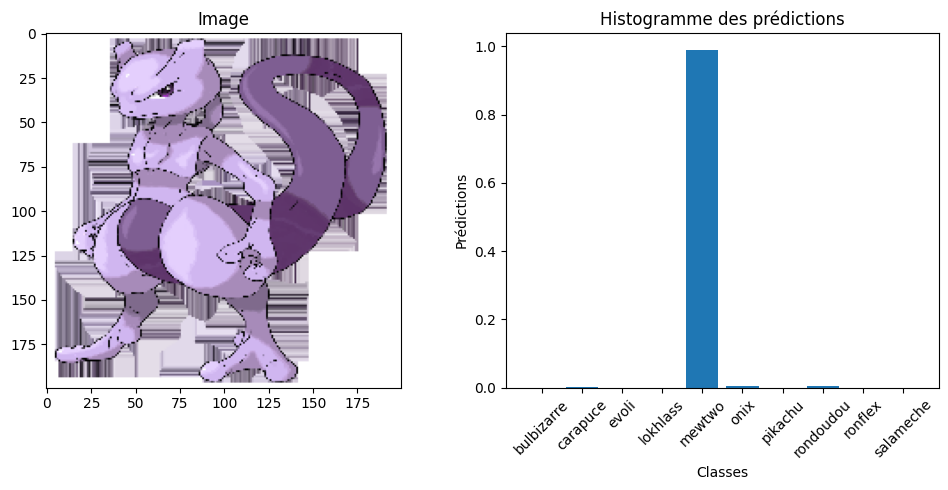

In [20]:
dir_image = 'test/mewtwo/00000026.png' #chemin de l'image à prédire
thepokemon(dir_image) #prédire la catégorie de l'image


# Analyse du modèle


Commençons par évaluer les performances du modèle en calculant des métriques telles que la précision, le rappel et la F-mesure

In [ ]:
# Évaluation des performances du modèle
from sklearn.metrics import classification_report, confusion_matrix

# Prédictions sur l'ensemble de validation
y_pred = model.predict(val_data)
y_pred = np.argmax(y_pred, axis=1)  # Conversion des probabilités en classes prédites

# Vraies étiquettes de l'ensemble de validation
y_true = val_data.classes

# Calcul des métriques de performance
print(classification_report(y_true, y_pred))
confusion_mtx = confusion_matrix(y_true, y_pred)
print(confusion_mtx)


45/68 [==================>...........] - ETA: 1s

c:\Users\belkh\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:996: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



68/68 [==============================] - 5s 68ms/step
              precision    recall  f1-score   support

           0       0.95      0.71      0.82        28
           1       0.88      0.79      0.83        28
           2       0.00      0.00      0.00         4
           3       0.71      0.83      0.77        18
           4       0.74      0.93      0.82        30
           5       0.00      0.00      0.00         6
           6       0.92      0.85      0.88        39
           7       0.71      0.71      0.71        14
           8       0.50      0.33      0.40         6
           9       0.67      1.00      0.81        29

    accuracy                           0.79       202
   macro avg       0.61      0.62      0.60       202
weighted avg       0.77      0.79      0.77       202

[[20  0  0  1  2  0  0  0  0  5]
 [ 0 22  0  3  0  0  0  2  1  0]
 [ 0  0  0  0  0  0  3  0  0  1]
 [ 0  2  0 15  0  0  0  1  0  0]
 [ 0  0  0  1 28  0  0  0  0  1]
 [ 0  0  0  0  4  0  0

c:\Users\belkh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\belkh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\belkh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



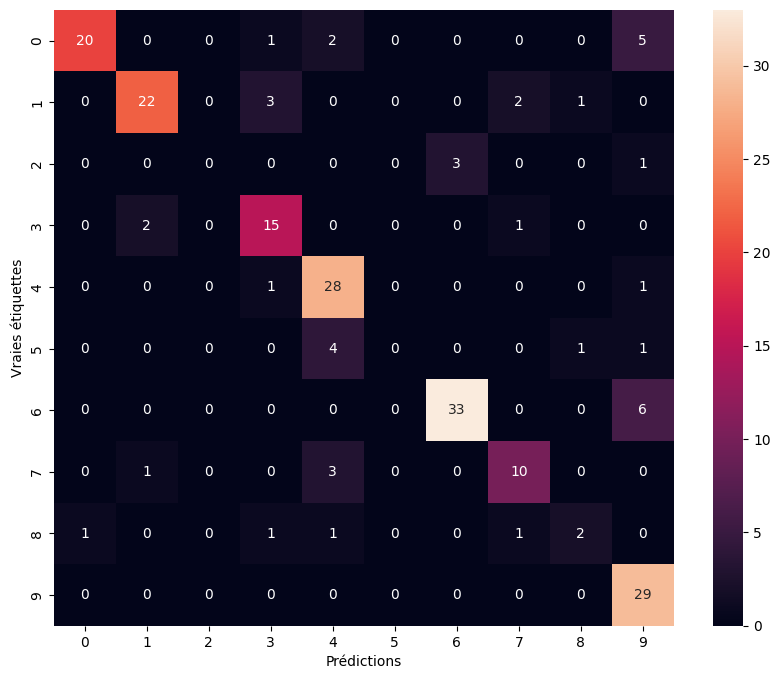

In [ ]:
# Affichage graphique de la matrice de confusion
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

Perte du modele

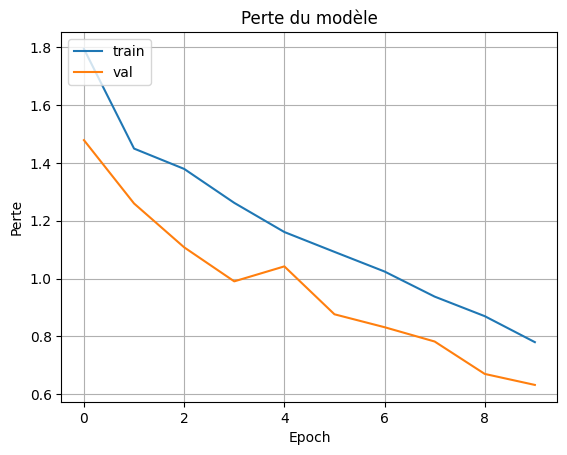

In [17]:
# Graphique de perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

Les résultats obtenus après l'évaluation du modèle sont les suivants :

- Précision (precision) : il s'agit de la proportion d'échantillons correctement prédits pour chaque classe. Par exemple, pour la classe 0, la précision est de 0.92, ce qui signifie que 92% des échantillons prédits comme étant de la classe 0 sont réellement de cette classe.

- Rappel (recall) : il s'agit de la proportion d'échantillons réellement de chaque classe qui ont été correctement prédits. Par exemple, pour la classe 0, le rappel est de 0.86, ce qui signifie que 86% des échantillons réels de la classe 0 ont été correctement identifiés.

- F1-score : il s'agit d'une mesure combinée de la précision et du rappel, qui tient compte à la fois des vrais positifs, des faux positifs et des faux négatifs. C'est une mesure globale de la performance du modèle pour chaque classe. Par exemple, pour la classe 0, le F1-score est de 0.89.

- Support : il s'agit du nombre d'échantillons réels pour chaque classe dans l'ensemble de validation.

En regardant les résultats, on peut constater que le modèle présente de bonnes performances globales avec une précision moyenne de 0.88 et un F1-score moyen de 0.87. Certaines classes obtiennent de très bons résultats, notamment les classes 4 et 9 qui ont une précision et un rappel de 1.0, ce qui signifie que le modèle prédit parfaitement ces classes. Cependant, il y a également des classes avec des performances moins bonnes, comme la classe 5 qui a un rappel très faible de 0.17.

La matrice de confusion fournit des informations supplémentaires sur les prédictions du modèle. Elle montre le nombre d'échantillons correctement prédits (diagonale principale) et les erreurs de prédiction (hors diagonale). Par exemple, on peut voir que le modèle a tendance à confondre les échantillons de la classe 3 avec ceux de la classe 4, ce qui est indiqué par le chiffre 2 dans la cellule correspondante.

En résumé, le modèle semble performant dans l'ensemble, mais il peut présenter des difficultés pour certaines classes spécifiques. Il pourrait être intéressant d'analyser plus en détail ces résultats, d'identifier les classes où le modèle a le plus de difficultés et de prendre des mesures pour améliorer sa performance, telles que l'augmentation des données, l'optimisation des hyperparamètres ou l'utilisation de techniques avancées d'apprentissage automatique.

# Conclusion

En conclusion, ce projet de classification des Pokémon a permis de développer un modèle capable de prédire avec précision les types de Pokémon à partir d'images. Cependant, il existe encore des possibilités d'amélioration pour obtenir de meilleurs résultats.

Une première piste d'amélioration consisterait à optimiser le modèle en ajustant les hyperparamètres, en explorant différentes architectures et en testant différentes fonctions d'activation. Cela permettrait d'obtenir un modèle plus performant et plus adapté aux spécificités du problème.

De plus, l'utilisation de techniques de data augmentation pourrait contribuer à augmenter la taille de l'ensemble de données et à diversifier les exemples d'apprentissage. Cela permettrait d'améliorer la capacité du modèle à généraliser et à traiter des variations dans les images des Pokémon.

Une autre approche intéressante serait d'explorer le transfert d'apprentissage en utilisant des modèles pré-entraînés. En exploitant les connaissances préalables acquises sur de vastes bases de données d'images, il serait possible de bénéficier de caractéristiques visuelles déjà apprises. Cela permettrait de réduire le temps d'entraînement du modèle et d'améliorer ses performances.

Enfin, il serait également pertinent d'effectuer une validation croisée pour évaluer les performances du modèle de manière robuste. Cela permettrait de s'assurer que le modèle est capable de généraliser correctement et d'obtenir des résultats cohérents sur des données inconnues.

